In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch.nn as nn
from torch import (Tensor, IntTensor, ones, zeros, optim, save,
                    load, randint)
from torch import float as tfloat
import numpy as np
import matplotlib.pyplot as plt
from src.diff_utils import (
    ConvType, DataType, device, channel_map, conv_map, heat_1d_loss, heat_2d_loss,
    num_T, num_X, num_Y, T_max, Y_max, X_max, label_dim_map, get_label_name, num_classes_map
)
from src.visual_util import (
    sampling_traj, show_img_from_tensor, pick_random_label, denoise, show_img, make_gif
)
from src.vdm import VDM_Decoder, VDM_Encoder
from src.dataset_loader import load_dataset

2024-04-23 14:32:15.531566: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-23 14:32:16.205005: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [5]:
define_models = True
training = True

conv_type = ConvType.Conv2d
data_type = DataType.images
T = 1024
if define_models:
    e = VDM_Encoder(T, conv_type).to(device)
    d = VDM_Decoder(T, num_channels=channel_map[conv_type][data_type], label_dim=label_dim_map[data_type], num_classes=num_classes_map[data_type], conv_map=conv_map[conv_type][data_type], conv_type=conv_type).to(device)
else:
    e = load(f'models/{data_type.name}/model-enc.pkl', map_location=device)
    d = load(f'models/{data_type.name}/model-dec.pkl', map_location=device)
times = IntTensor(np.linspace(0, T, T+1, dtype=int)).to(device)

In [6]:
base_loss_fn = nn.L1Loss()

lr = 2e-4
optimizer = optim.AdamW(d.parameters(), lr=lr)
batch_size = 64
epochs = 500 if training else 0

args = {
    "lr": lr,
    "optimizer": optimizer,
    "batch_size": batch_size,
    "epochs": epochs,
    "conv_type": conv_type,
    "data_type": data_type,
    "training": training,
    "num_T": num_T,
    "num_Y": num_Y,
    "num_X": num_X
}

dataset_dict = load_dataset(args)
dataset = dataset_dict['train_dataset']
train_dataloader = dataset_dict['train_dataloader']

remove

In [ ]:
# x1, y1 = dataset[1]

# print(x1.shape)
# print(y1.shape)

In [ ]:
# make_gif('t.gif', x1[0].cpu().detach().numpy(), 8)

# print(x1[None,:,:,:,:].shape)

# ls, res = heat_2d_loss(x1[None,:,:,:,:], y1[None,:], Tensor([np.arange(1)]).to(device).T, conv_type, T)
# print(y1)
# print(ls)
# print(res)

end remove

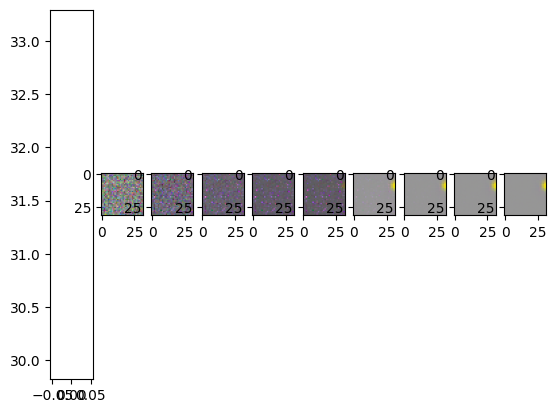

Condition: dog
total_loss=31.55763844029068
Epoch 1 finished.


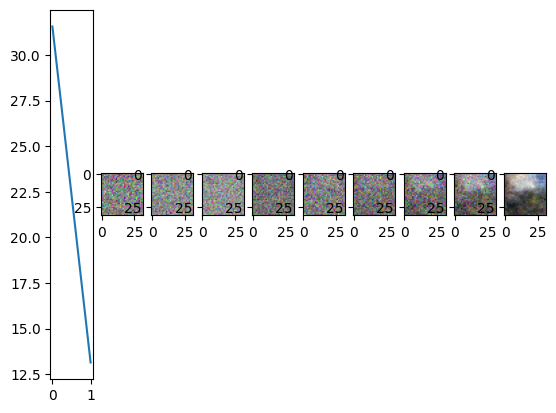

Condition: bird
total_loss=13.140240901571406
Epoch 2 finished.


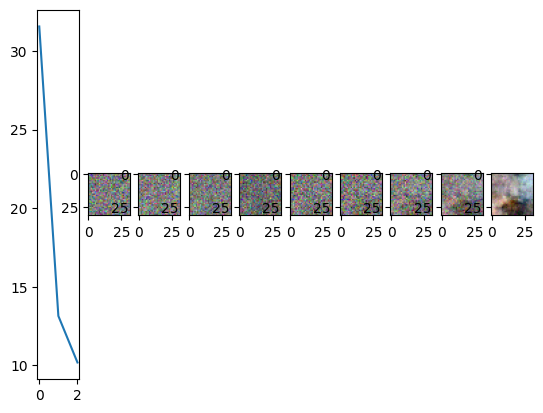

Condition: cat
total_loss=10.18179175768362
Epoch 3 finished.


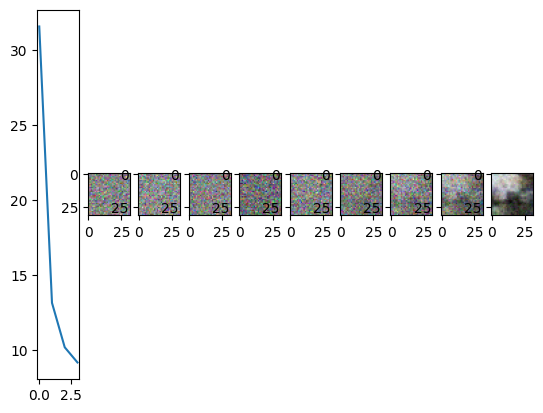

Condition: horse
total_loss=9.169453214044156
Epoch 4 finished.


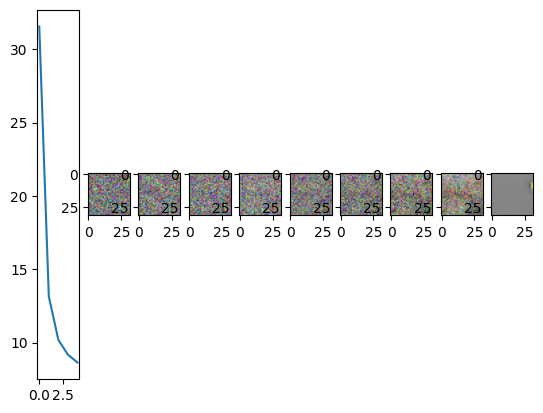

Condition: automobile
total_loss=8.638656619259768
Epoch 5 finished.


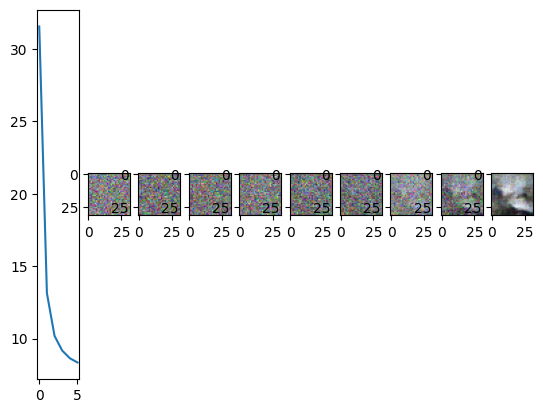

Condition: dog
total_loss=8.346064441344318
Epoch 6 finished.


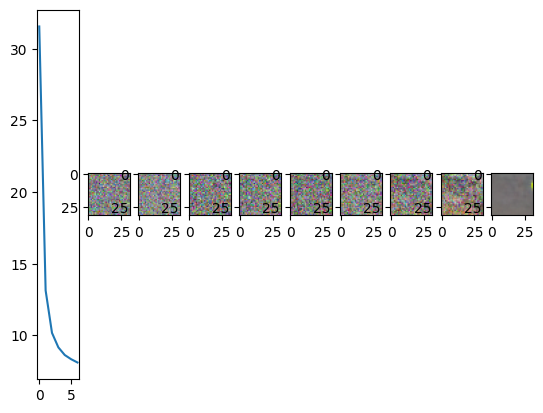

Condition: automobile
total_loss=8.116808644036198
Epoch 7 finished.


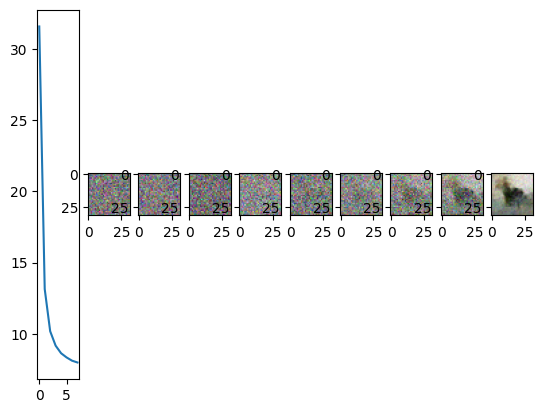

Condition: dog
total_loss=7.990841571022482
Epoch 8 finished.


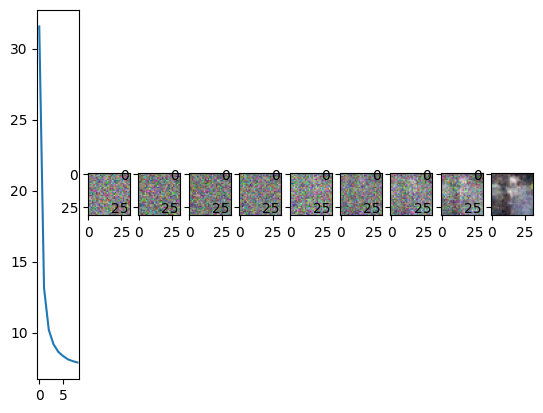

Condition: deer
total_loss=7.896567423935132
Epoch 9 finished.


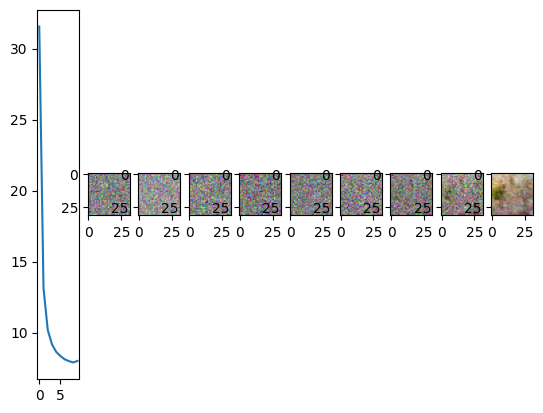

Condition: deer
total_loss=8.004861588063447
Epoch 10 finished.


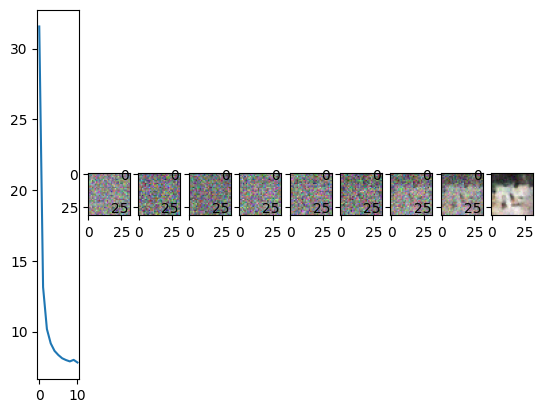

Condition: dog
total_loss=7.820373301310918
Epoch 11 finished.


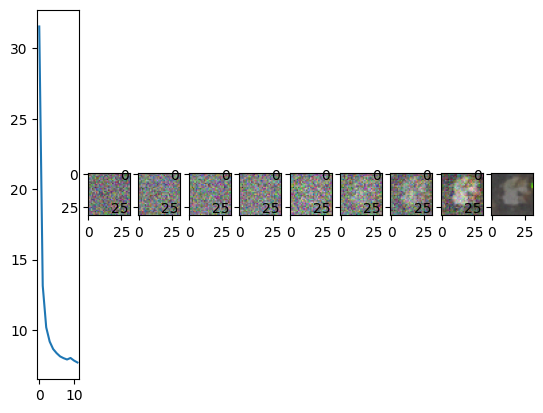

Condition: automobile
total_loss=7.684647850368334
Epoch 12 finished.


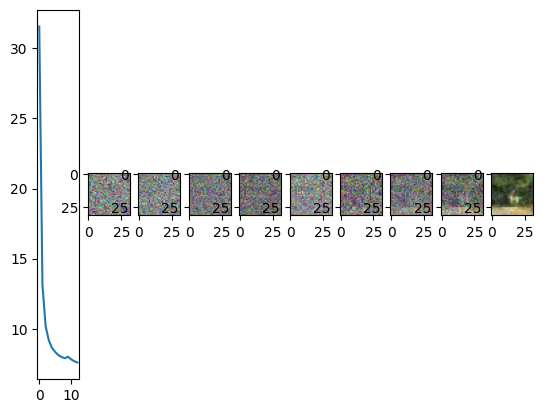

Condition: dog
total_loss=7.595368681051542
Epoch 13 finished.


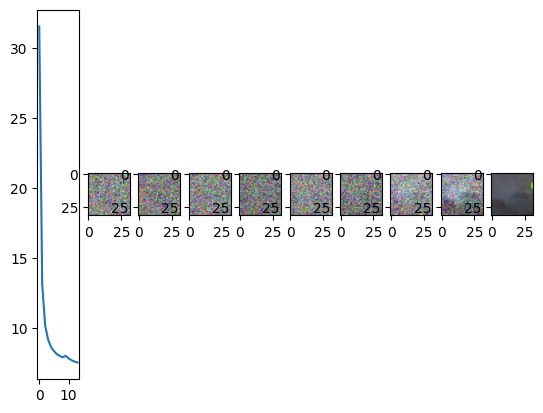

Condition: ship
total_loss=7.529304841900116
Epoch 14 finished.


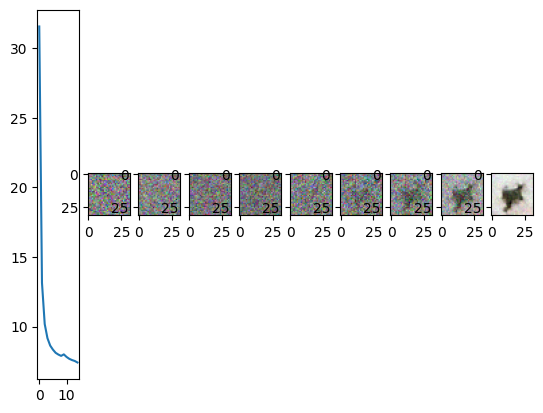

Condition: truck
total_loss=7.422067068421932
Epoch 15 finished.


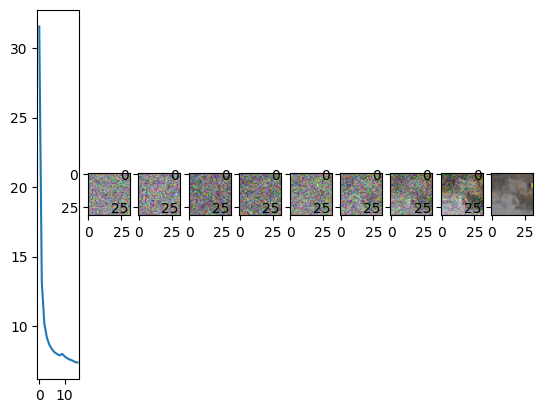

Condition: cat
total_loss=7.385944971648018
Epoch 16 finished.


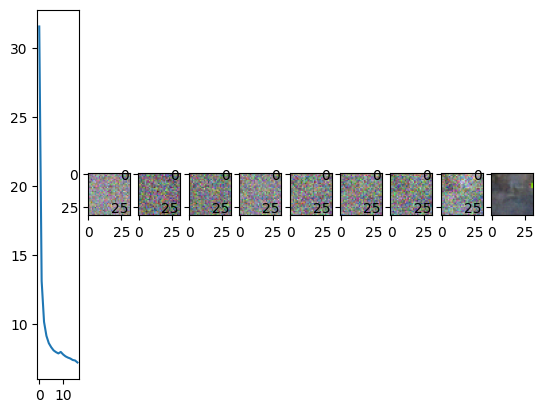

Condition: airplane
total_loss=7.24151623645402
Epoch 17 finished.


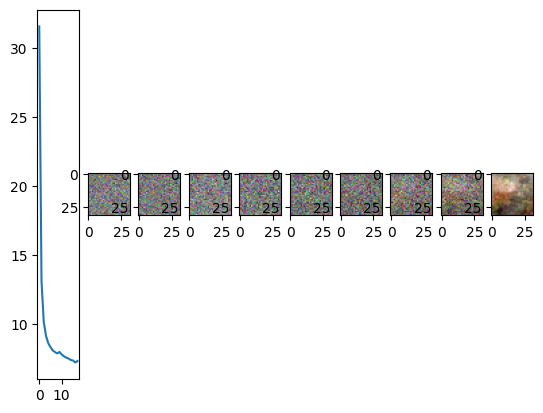

Condition: frog
total_loss=7.341734015118435
Epoch 18 finished.


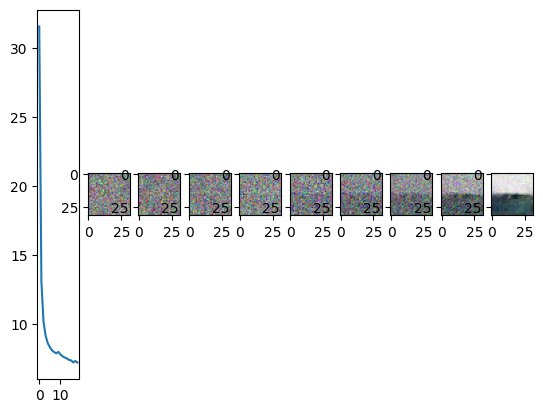

Condition: ship
total_loss=7.237286029264445
Epoch 19 finished.


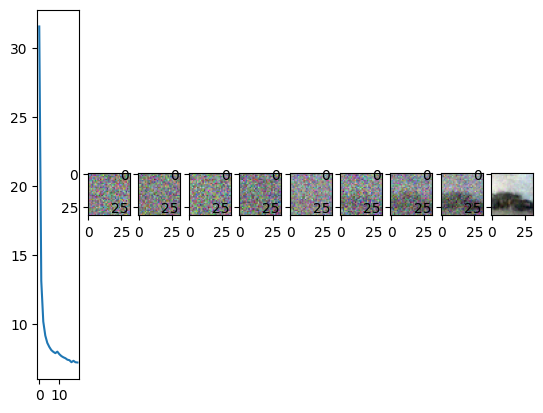

Condition: truck
total_loss=7.22058373735384
Epoch 20 finished.


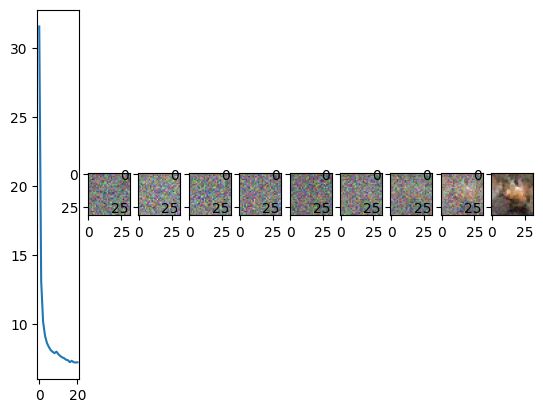

Condition: deer
total_loss=7.233785186277326
Epoch 21 finished.


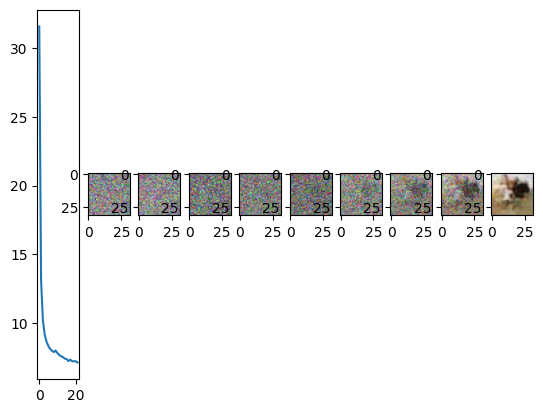

Condition: horse
total_loss=7.138591396229346
Epoch 22 finished.


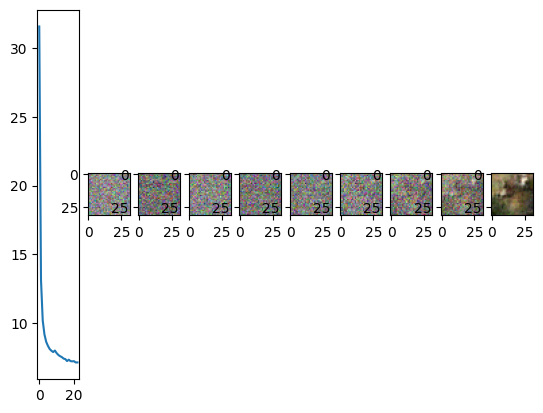

Condition: frog
total_loss=7.142808014779445
Epoch 23 finished.


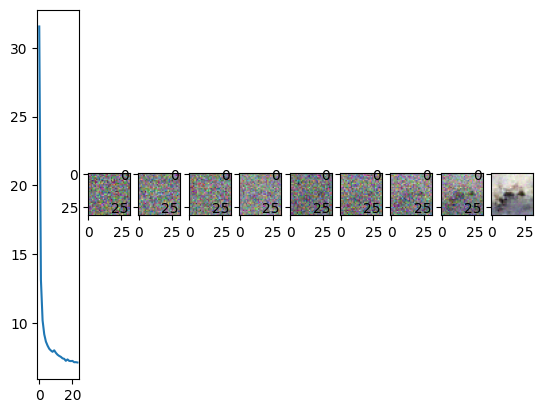

Condition: bird
total_loss=7.119844219568745
Epoch 24 finished.


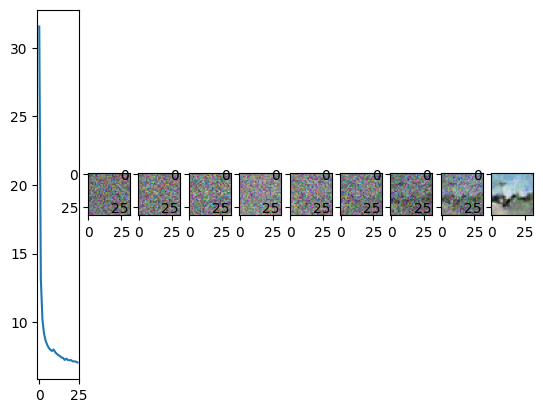

Condition: truck
total_loss=7.059557442165092
Epoch 25 finished.


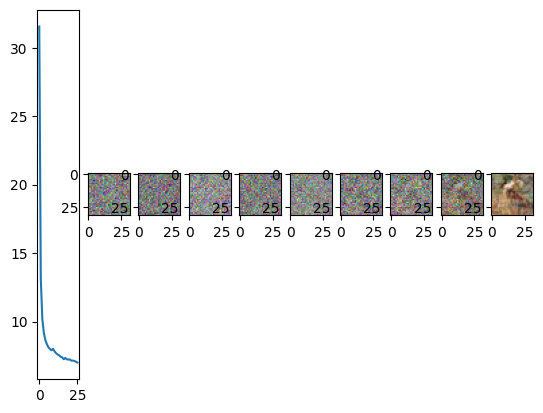

Condition: horse
total_loss=7.006463148709758
Epoch 26 finished.


In [7]:
losses = []
d.train()
for epoch in range(epochs):
    total_loss = 0

    for inp, label in train_dataloader:
        optimizer.zero_grad()
        
        inp = inp.to(device, dtype=tfloat)
        times_i = randint(1, T+1, (inp.shape[0],)).to(device)
        
        x_i, eps = e(inp, times_i) # x_{i}, eps_true ~ q(x_{i} | x_{0})
        pred_eps = d(x_i, times_i, label) # eps_theta_{i} ~ p(x_{i-1} | x_{i})

        loss = base_loss_fn(pred_eps, eps)

        if data_type == DataType.heat_1d:
            pred_x_i1 = d.sample(x_i, times_i, label)
            loss += heat_1d_loss(pred_x_i1, label, times_i, conv_type, T)
        elif data_type == DataType.heat_2d:
            pred_x_i1 = d.sample(x_i, times_i, label)
            loss += heat_2d_loss(pred_x_i1, label, times_i, conv_type, T)

        total_loss += loss.item() * inp.shape[0]

        loss.backward()
        optimizer.step()
    total_loss /= len(train_dataloader)
    losses += [total_loss]
    
    if True:
        num_images = 9
        plt.subplot(1, num_images+1, 1)
        plt.plot(losses)
        # plt.show()
        if conv_type == ConvType.Conv2d:
            traj, cond = sampling_traj(d, e.reparameterize(zeros(x_i[0:1,:,:,:].shape).to(device), ones(x_i[0:1,:,:,:].shape).to(device))[0], T, times, pick_random_label(data_type), num_images)
            for i in range(num_images):
                plt.subplot(1, num_images+1, i+2)
                if data_type == DataType.mnist:
                    show_img_from_tensor(traj[i][0])
                elif data_type == DataType.heat_1d:
                    show_img_from_tensor(traj[i].moveaxis(1,3).reshape(1, x_i.shape[3], x_i.shape[1]))
                elif data_type == DataType.images:
                    show_img_from_tensor(traj[i].moveaxis(1,3))
        else:
            traj, cond = sampling_traj(d, e.reparameterize(zeros(x_i[0:1,:,:,:,:].shape).to(device), ones(x_i[0:1,:,:,:,:].shape).to(device))[0], T, times, pick_random_label(data_type), num_images)
            for i in range(num_images):
                plt.subplot(1, num_images+1, i+2)
                if data_type == DataType.mnist:
                    show_img_from_tensor(traj[i][0,0])
                elif data_type == DataType.heat_1d:
                    show_img_from_tensor(traj[i][0].moveaxis(1,3).reshape(1, x_i.shape[4], x_i.shape[2]))
                elif data_type == DataType.heat_2d:
                    show_img_from_tensor(traj[i][0,0,-1].reshape(1, x_i.shape[4], x_i.shape[3]))
        plt.show()

    print(f"Condition: {get_label_name(data_type, cond.cpu().detach().numpy()[0])}\n{total_loss=}\nEpoch {epoch+1} finished.")

    save(e, f'models/{data_type.name}/model-enc.pkl')
    save(d, f'models/{data_type.name}/model-dec.pkl')

save(e, f'models/{data_type.name}/model-enc-MAX-EPOCHS.pkl')
save(d, f'models/{data_type.name}/model-dec-MAX-EPOCHS.pkl')

In [ ]:
x_test_i, y_test_i = dataset_dict['test_dataset'][6]
if data_type == DataType.mnist:
    base = Tensor(x_test_i[None,:,:]).to(device, dtype=tfloat)
    condition = Tensor(y_test_i).to(device, dtype=tfloat)
    # base = Tensor(x_test).to(device, dtype=tfloat)[655]
    # x_T, eps = e(base, times[T:T+1])
    x_T = zeros((1,1,32,32))
elif data_type == DataType.images:
    base = Tensor(x_test_i).to(device, dtype=tfloat)
    condition = Tensor(y_test_i).to(device, dtype=tfloat)
    # base = Tensor(x_test).to(device, dtype=tfloat)[655]
    # x_T, eps = e(base, times[T:T+1])
    x_T = zeros((1,3,32,32))
elif data_type == DataType.heat_1d:
    base = Tensor(x_test_i).to(device, dtype=tfloat)
    condition = Tensor(y_test_i).to(device, dtype=tfloat)
    x_T = zeros((1,32,1,32))
elif data_type == DataType.heat_2d:
    base = Tensor(x_test_i).to(device, dtype=tfloat)
    condition = Tensor(y_test_i).to(device, dtype=tfloat)
    # condition[0] = 1.0
    x_T = zeros((1,num_T,32,32))

if conv_type == ConvType.Conv3d:
    x_T = x_T[None,:,:,:,:]

print(condition)
x_T = e.reparameterize(zeros(x_T.shape).to(device), ones(x_T.shape).to(device))[0] # this is for sampling from pure noise
show_img(base.reshape(3,32,32))
show_img(x_T[0].reshape(3,32,32))

In [ ]:
x_T = e.reparameterize(zeros(x_T.shape).to(device), ones(x_T.shape).to(device))[0] # this is for sampling from pure noise
show_img(x_T[0].reshape(3,32,32))

x_T = (denoise(d, x_T, T, times, condition.reshape(1,1)) + 1) / 2 # remap from [-1, 1] to [0, 1]
show_img(x_T[0].reshape(3,32,32))
# make_gif('visuals/5-512T-1200func-96x32x32-BASE.gif', base[0].cpu().detach().numpy(), num_T, 8)
# make_gif('visuals/5-512T-1200func-96x32x32-GENERATED.gif', x_T[0,0].cpu().detach().numpy(), num_T, 8)

In [ ]:
# num_images = 9
# if data_type == DataType.mnist:
#     label = Tensor([[np.random.randint(10)]]).to(device)
# elif data_type == DataType.heat_1d:
#     label = Tensor([[np.random.random() * 2]]).to(device)
# traj, cond = sampling_traj(e.reparameterize(zeros(x_T.shape).to(device), ones(x_T.shape).to(device))[0], T, label, num_images)
# for i in range(num_images):
#     plt.subplot(1, num_images+1, i+2)
#     show_img_from_tensor(traj[i][0,0].swapaxes(0,2).reshape(1,32,32))
# plt.show()
# print(cond.cpu().detach().item())

In [ ]:
# !jupyter nbconvert --to script vdm.ipynb 